[![ Click here to deploy.](https://uohmivykqgnnbiouffke.supabase.co/storage/v1/object/public/landingpage/brevdeploynavy.svg)](https://console.brev.dev/launchable/deploy/now?launchableID=env-2rgiXa7D63Aq0bmKElJq2HpAY2x)

NOTE: it takes about 10 minutes to deploy this notebook as a Launchable. As of this writing, we are working on a free tier so a credit card may be required. You can reach out to your NVIDIA rep for credits."

# Building Generative Models for Continuous Data via Continuous Interpolants

In [1]:
import math

import matplotlib.pyplot as plt
import torch
from sklearn.datasets import make_moons

# Task Setup

To demonstrate how Conditional Flow Matching works we use sklearn to sample from and create custom 2D distriubtions.

To start we define our "dataloader" so to speak. This is the '''sample_moons''' function.

Next we define a custom PriorDistribution to enable the conversion of 8 equidistance gaussians to the moon distribution above.



In [2]:
def sample_moons(n, normalize=False):
    x1, _ = make_moons(n_samples=n, noise=0.08)
    x1 = torch.Tensor(x1)
    x1 = x1 * 3 - 1
    if normalize:
        x1 = (x1 - x1.mean(0)) / x1.std(0) * 2
    return x1

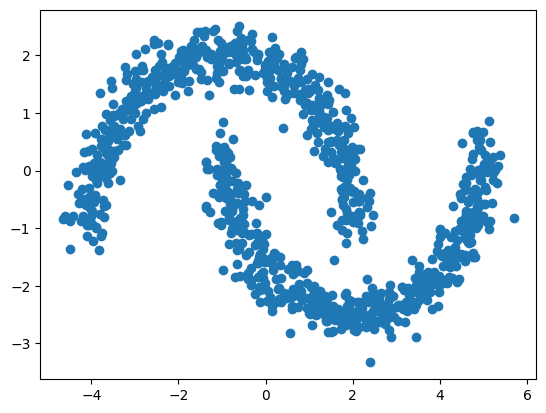

In [3]:
x1 = sample_moons(1000)
plt.scatter(x1[:, 0], x1[:, 1])

# Model Creation
Here we define a simple 4 layer MLP and define our optimizer

In [4]:
dim = 2
hidden_size = 64
batch_size = 256
model = torch.nn.Sequential(
    torch.nn.Linear(dim + 1, hidden_size),
    torch.nn.SELU(),
    torch.nn.Linear(hidden_size, hidden_size),
    torch.nn.SELU(),
    torch.nn.Linear(hidden_size, hidden_size),
    torch.nn.SELU(),
    torch.nn.Linear(hidden_size, dim),
)
optimizer = torch.optim.Adam(model.parameters())

# Continuous Flow Matching Interpolant
Here we import our desired interpolant objects.

The continuous flow matcher and the desired time distribution.

In [5]:
from bionemo.moco.distributions.prior import GaussianPrior
from bionemo.moco.distributions.time import UniformTimeDistribution
from bionemo.moco.interpolants import ContinuousFlowMatcher


uniform_time = UniformTimeDistribution()
simple_prior = GaussianPrior()
sigma = 0.1
cfm = ContinuousFlowMatcher(
    time_distribution=uniform_time, prior_distribution=simple_prior, sigma=sigma, prediction_type="velocity"
)
# Place both the model and the interpolant on the same device
DEVICE = "cuda"
model = model.to(DEVICE)
cfm = cfm.to_device(DEVICE)

# Training Loop

In [6]:
for k in range(20000):
    optimizer.zero_grad()
    shape = (batch_size, dim)
    x0 = cfm.sample_prior(shape).to(DEVICE)
    x1 = sample_moons(batch_size).to(DEVICE)

    t = cfm.sample_time(batch_size)
    xt = cfm.interpolate(x1, t, x0)
    ut = cfm.calculate_target(x1, x0)

    vt = model(torch.cat([xt, t[:, None]], dim=-1))
    loss = cfm.loss(vt, ut, target_type="velocity").mean()

    loss.backward()
    optimizer.step()

    if (k + 1) % 5000 == 0:
        print(f"{k + 1}: loss {loss.item():0.3f}")

5000: loss 3.094
10000: loss 2.881
15000: loss 3.287
20000: loss 2.997


# Setting Up Generation
Now we need to import the desired inference time schedule. This is what gives us the time values to iterate through to iteratively generate from our model.

Here we show the output time schedule as well as the discretization between time points. We note that different inference time schedules may have different shapes resulting in non uniform dt

In [7]:
from bionemo.moco.schedules.inference_time_schedules import LinearInferenceSchedule


inference_sched = LinearInferenceSchedule(nsteps=100)
schedule = inference_sched.generate_schedule().to(DEVICE)
dts = inference_sched.discretize().to(DEVICE)
schedule, dts

(tensor([0.0000, 0.0100, 0.0200, 0.0300, 0.0400, 0.0500, 0.0600, 0.0700, 0.0800,
         0.0900, 0.1000, 0.1100, 0.1200, 0.1300, 0.1400, 0.1500, 0.1600, 0.1700,
         0.1800, 0.1900, 0.2000, 0.2100, 0.2200, 0.2300, 0.2400, 0.2500, 0.2600,
         0.2700, 0.2800, 0.2900, 0.3000, 0.3100, 0.3200, 0.3300, 0.3400, 0.3500,
         0.3600, 0.3700, 0.3800, 0.3900, 0.4000, 0.4100, 0.4200, 0.4300, 0.4400,
         0.4500, 0.4600, 0.4700, 0.4800, 0.4900, 0.5000, 0.5100, 0.5200, 0.5300,
         0.5400, 0.5500, 0.5600, 0.5700, 0.5800, 0.5900, 0.6000, 0.6100, 0.6200,
         0.6300, 0.6400, 0.6500, 0.6600, 0.6700, 0.6800, 0.6900, 0.7000, 0.7100,
         0.7200, 0.7300, 0.7400, 0.7500, 0.7600, 0.7700, 0.7800, 0.7900, 0.8000,
         0.8100, 0.8200, 0.8300, 0.8400, 0.8500, 0.8600, 0.8700, 0.8800, 0.8900,
         0.9000, 0.9100, 0.9200, 0.9300, 0.9400, 0.9500, 0.9600, 0.9700, 0.9800,
         0.9900], device='cuda:0'),
 tensor([0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 

# Sample from the trained model

In [8]:
inf_size = 1024
sample = cfm.sample_prior((inf_size, 2)).to(DEVICE)  # Start with noise
trajectory = [sample]
for dt, t in zip(dts, schedule):
    full_t = inference_sched.pad_time(inf_size, t, DEVICE)
    vt = model(
        torch.cat([sample, full_t[:, None]], dim=-1)
    )  # calculate the vector field based on the definition of the model
    sample = cfm.step(vt, sample, dt, full_t)
    trajectory.append(sample)  # save the trajectory for plotting purposes

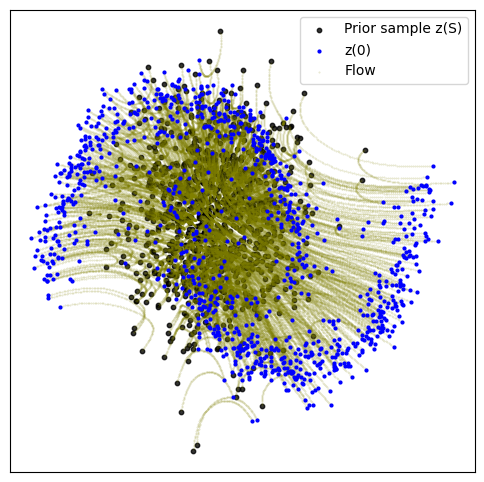

In [9]:
import matplotlib.pyplot as plt


traj = torch.stack(trajectory).cpu().detach().numpy()
plot_limit = 1024
plt.figure(figsize=(6, 6))

# Plot the first time point in black
plt.scatter(traj[0, :plot_limit, 0], traj[0, :plot_limit, 1], s=10, alpha=0.8, c="black", label="Prior sample z(S)")

# Plot all the rest of the time points except the first and last in olive
for i in range(1, traj.shape[0] - 1):
    plt.scatter(traj[i, :plot_limit, 0], traj[i, :plot_limit, 1], s=0.2, alpha=0.2, c="olive")

# Plot the last time point in blue
plt.scatter(traj[-1, :plot_limit, 0], traj[-1, :plot_limit, 1], s=4, alpha=1, c="blue", label="z(0)")

# Add a second legend for "Flow" since we can't label in the loop directly
plt.scatter([], [], s=0.2, alpha=0.2, c="olive", label="Flow")
plt.legend()
plt.xticks([])
plt.yticks([])
plt.show()

# Sample from underlying score model

##  low temperature sampling is a heuristic, unclear what effects it has on the final distribution. Intuitively, it cuts tails and focuses more on the mode, in practice who knows exactly what's the final effect.

## gt_mode is a hyperparameter that must be experimentally chosen

In [10]:
inf_size = 1024
sample = cfm.sample_prior((inf_size, 2)).to(DEVICE)
trajectory_stoch = [sample]
vts = []
for dt, t in zip(dts, schedule):
    time = inference_sched.pad_time(inf_size, t, DEVICE)  # torch.full((inf_size,), t).to(DEVICE)
    vt = model(torch.cat([sample, time[:, None]], dim=-1))
    sample = cfm.step_score_stochastic(vt, sample, dt, time, noise_temperature=1.0, gt_mode="tan")
    trajectory_stoch.append(sample)
    vts.append(vt)

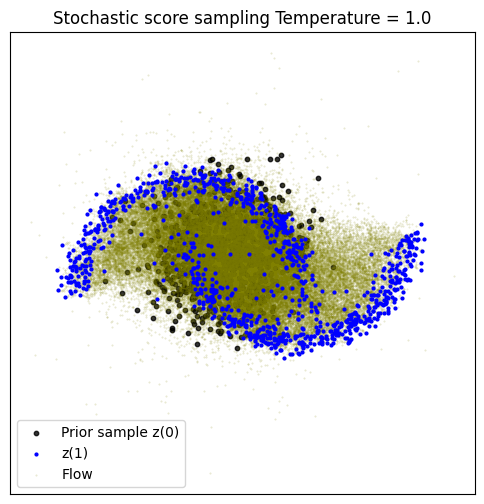

In [11]:
traj = torch.stack(trajectory_stoch).cpu().detach().numpy()
plot_limit = 1024
plt.figure(figsize=(6, 6))

# Plot the first time point in black
plt.scatter(traj[0, :plot_limit, 0], traj[0, :plot_limit, 1], s=10, alpha=0.8, c="black", label="Prior sample z(0)")

# Plot all the rest of the time points except the first and last in olive
for i in range(1, traj.shape[0] - 1):
    plt.scatter(traj[i, :plot_limit, 0], traj[i, :plot_limit, 1], s=0.2, alpha=0.2, c="olive")
# Plot the last time point in blue
plt.scatter(traj[-1, :plot_limit, 0], traj[-1, :plot_limit, 1], s=4, alpha=1, c="blue", label="z(1)")

# Add a second legend for "Flow" since we can't label in the loop directly
plt.scatter([], [], s=0.2, alpha=0.2, c="olive", label="Flow")
plt.legend()
plt.xticks([])
plt.yticks([])
plt.title("Stochastic score sampling Temperature = 1.0")
plt.show()

# What happens if you just sample from a random model?

In [12]:
fmodel = torch.nn.Sequential(
    torch.nn.Linear(dim + 1, hidden_size),
    torch.nn.SELU(),
    torch.nn.Linear(hidden_size, hidden_size),
    torch.nn.SELU(),
    torch.nn.Linear(hidden_size, hidden_size),
    torch.nn.SELU(),
    torch.nn.Linear(hidden_size, dim),
).to(DEVICE)
inf_size = 1024
sample = cfm.sample_prior((inf_size, 2)).to(DEVICE)
trajectory2 = [sample]
for dt, t in zip(dts, schedule):
    time = inference_sched.pad_time(inf_size, t, DEVICE)  # torch.full((inf_size,), t).to(DEVICE)
    vt = fmodel(torch.cat([sample, time[:, None]], dim=-1))
    sample = cfm.step(vt, sample, dt, time)
    trajectory2.append(sample)

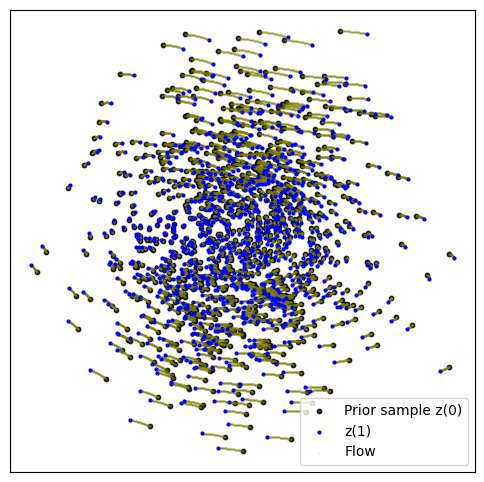

In [13]:
plot_limit = 1024
traj = torch.stack(trajectory2).cpu().detach().numpy()

plt.figure(figsize=(6, 6))

# Plot the first time point in black
plt.scatter(traj[0, :plot_limit, 0], traj[0, :plot_limit, 1], s=10, alpha=0.8, c="black", label="Prior sample z(0)")

# Plot all the rest of the time points except the first and last in olive
for i in range(1, traj.shape[0] - 1):
    plt.scatter(traj[i, :plot_limit, 0], traj[i, :plot_limit, 1], s=0.2, alpha=0.2, c="olive")

# Plot the last time point in blue
plt.scatter(traj[-1, :plot_limit, 0], traj[-1, :plot_limit, 1], s=4, alpha=1, c="blue", label="z(1)")

# Add a second legend for "Flow" since we can't label in the loop directly
plt.scatter([], [], s=0.2, alpha=0.2, c="olive", label="Flow")
plt.legend()
plt.xticks([])
plt.yticks([])
plt.show()

# Now let's try a different Interpolant type

## Let's create an architecture that has a formal time embedding as here we use more timesteps

In [14]:
from typing import List

import torch
import torch.nn as nn
import torch.nn.functional as F


class Network(nn.Module):
    def __init__(
        self,
        dim_in: int,
        dim_out: int,
        dim_hids: List[int],
    ):
        super().__init__()
        self.layers = nn.ModuleList(
            [
                TimeLinear(dim_in, dim_hids[0]),
                *[TimeLinear(dim_hids[i - 1], dim_hids[i]) for i in range(1, len(dim_hids))],
                TimeLinear(dim_hids[-1], dim_out),
            ]
        )

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        for i, layer in enumerate(self.layers):
            x = layer(x, t)
            if i < len(self.layers) - 1:
                x = F.relu(x)
        return x


class TimeLinear(nn.Module):
    def __init__(self, dim_in: int, dim_out: int):
        super().__init__()
        self.dim_in = dim_in
        self.dim_out = dim_out

        self.time_embedding = TimeEmbedding(dim_out)
        self.fc = nn.Linear(dim_in, dim_out)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.fc(x)
        alpha = self.time_embedding(t).view(-1, self.dim_out)
        return alpha * x


class TimeEmbedding(nn.Module):
    # https://github.com/openai/glide-text2im/blob/main/glide_text2im/nn.py
    def __init__(self, hidden_size, frequency_embedding_size=256):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(frequency_embedding_size, hidden_size, bias=True),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size, bias=True),
        )
        self.frequency_embedding_size = frequency_embedding_size

    @staticmethod
    def timestep_embedding(t, dim, max_period=10000):
        """
        Create sinusoidal timestep embeddings.
        :param t: a 1-D Tensor of N indices, one per batch element.
                          These may be fractional.
        :param dim: the dimension of the output.
        :param max_period: controls the minimum frequency of the embeddings.
        :return: an (N, D) Tensor of positional embeddings.
        """
        # https://github.com/openai/glide-text2im/blob/main/glide_text2im/nn.py
        half = dim // 2
        freqs = torch.exp(-math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half).to(
            device=t.device
        )
        args = t[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
        return embedding

    def forward(self, t: torch.Tensor):
        if t.ndim == 0:
            t = t.unsqueeze(-1)
        t_freq = self.timestep_embedding(t, self.frequency_embedding_size)
        t_emb = self.mlp(t_freq)
        return t_emb

# DDPM Interpolant
### note DDPM must be used with a Gaussian Prior.

In [15]:
from bionemo.moco.distributions.prior import GaussianPrior
from bionemo.moco.distributions.time import UniformTimeDistribution
from bionemo.moco.interpolants import DDPM
from bionemo.moco.schedules.inference_time_schedules import DiscreteLinearInferenceSchedule
from bionemo.moco.schedules.noise.discrete_noise_schedules import (
    DiscreteLinearNoiseSchedule,
)


DEVICE = "cuda:0"
uniform_time = UniformTimeDistribution(discrete_time=True, nsteps=1000)
simple_prior = GaussianPrior()
ddpm = DDPM(
    time_distribution=uniform_time,
    prior_distribution=simple_prior,
    prediction_type="noise",
    noise_schedule=DiscreteLinearNoiseSchedule(nsteps=1000),
    device=DEVICE,
)

## Train the Model

In [16]:
# Place both the model and the interpolant on the same device
dim = 2
hidden_size = 128
num_hiddens = 3
batch_size = 256
model = Network(dim_in=dim, dim_out=dim, dim_hids=[hidden_size] * num_hiddens)
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)
DEVICE = "cuda"
model = model.to(DEVICE)
ddpm = ddpm.to_device(DEVICE)
for k in range(20000):
    optimizer.zero_grad()
    shape = (batch_size, dim)
    x0 = ddpm.sample_prior(shape).to(DEVICE)
    x1 = sample_moons(batch_size).to(DEVICE)

    t = ddpm.sample_time(batch_size)
    xt = ddpm.interpolate(x1, t, x0)

    eps = model(xt, t)
    loss = ddpm.loss(eps, x0, t).mean()

    loss.backward()
    optimizer.step()

    if (k + 1) % 1000 == 0:
        print(f"{k + 1}: loss {loss.item():0.3f}")

1000: loss 0.342
2000: loss 0.334
3000: loss 0.291
4000: loss 0.308
5000: loss 0.285
6000: loss 0.282
7000: loss 0.353
8000: loss 0.359
9000: loss 0.342
10000: loss 0.373
11000: loss 0.327
12000: loss 0.364
13000: loss 0.297
14000: loss 0.345
15000: loss 0.315
16000: loss 0.358
17000: loss 0.290
18000: loss 0.253
19000: loss 0.295
20000: loss 0.373


## Let's vizualize what the interpolation looks like during training for different times

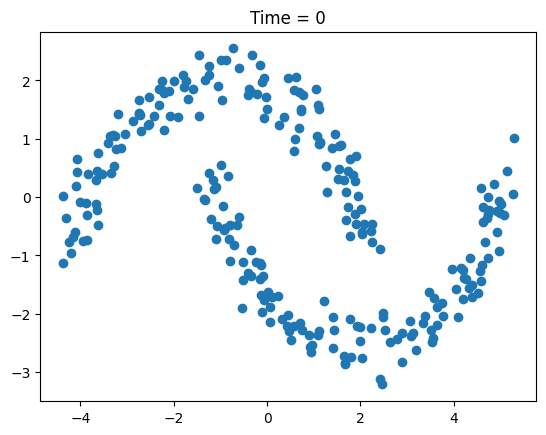

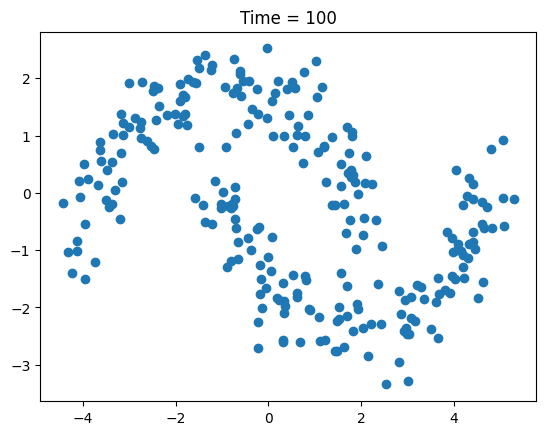

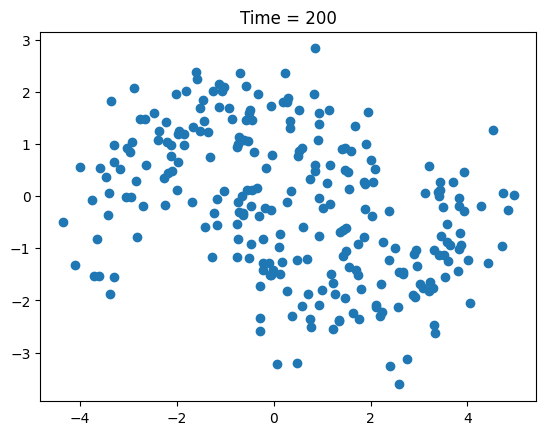

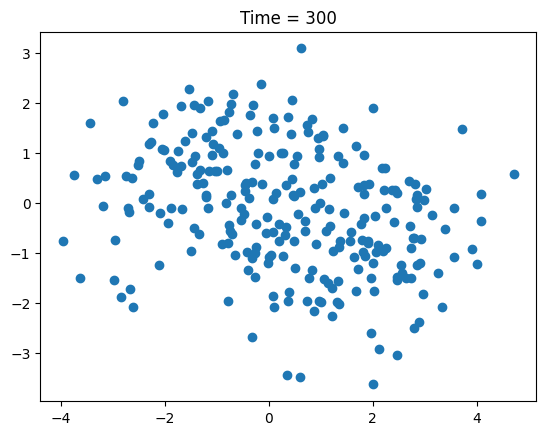

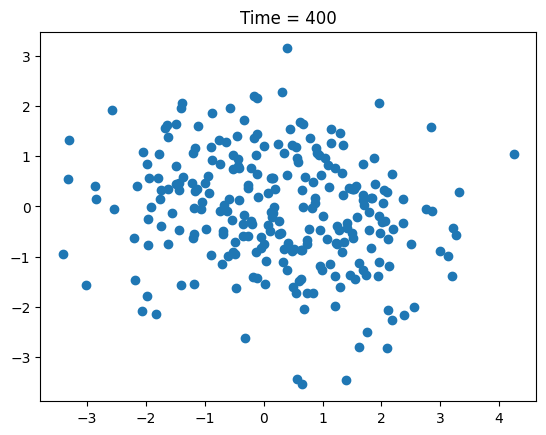

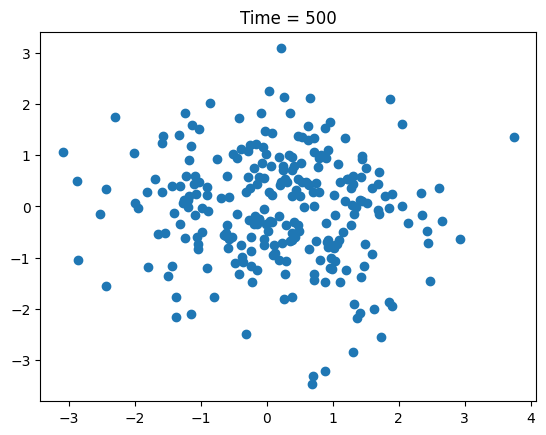

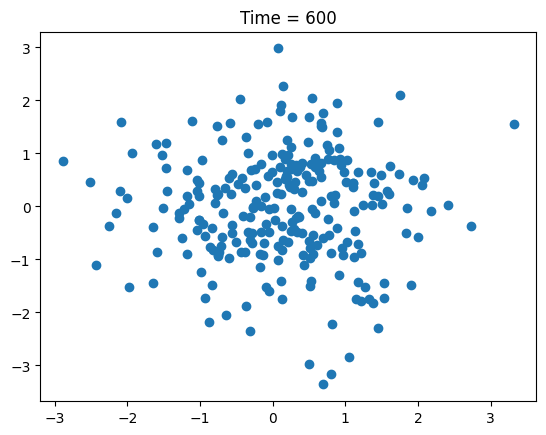

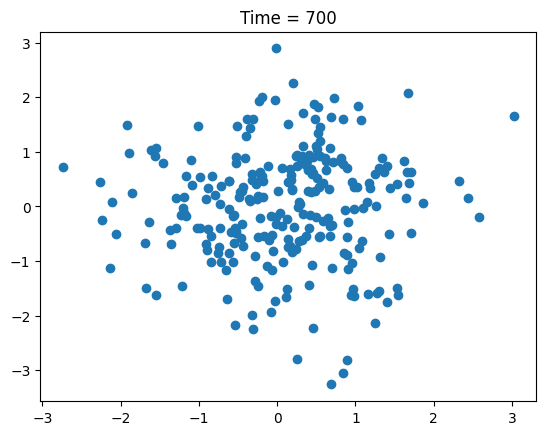

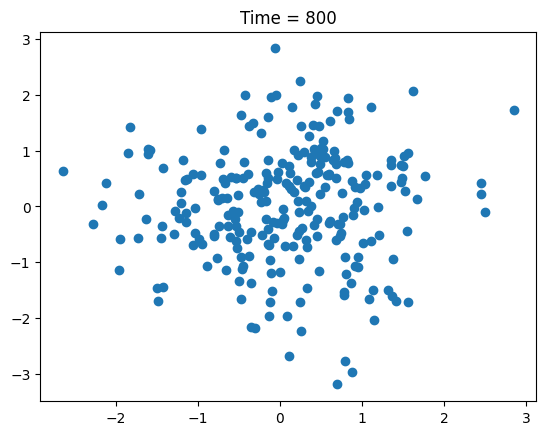

In [17]:
x0 = ddpm.sample_prior(shape).to(DEVICE)
x1 = sample_moons(batch_size).to(DEVICE)
for t in range(0, 900, 100):
    tt = ddpm.sample_time(batch_size) * 0 + t
    out = ddpm.interpolate(x1, tt, x0)
    plt.scatter(out[:, 0].cpu().detach(), out[:, 1].cpu().detach())
    plt.title(f"Time = {t}")
    plt.show()

## Create the inference time schedule and sample from the model

In [18]:
inf_size = 1024
schedule = DiscreteLinearInferenceSchedule(nsteps=1000, direction="diffusion").generate_schedule(device=DEVICE)
sample = ddpm.sample_prior((inf_size, 2)).to(DEVICE)  # Start with noise
trajectory = [sample]
for t in schedule:
    full_t = torch.full((inf_size,), t).to(DEVICE)
    vt = model(sample, full_t)  # calculate the vector field based on the definition of the model
    sample = ddpm.step_noise(vt, full_t, sample)
    trajectory.append(sample)  # save the trajectory for plotting purposes

/home/dreidenbach/mambaforge/envs/moco_bionemo/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


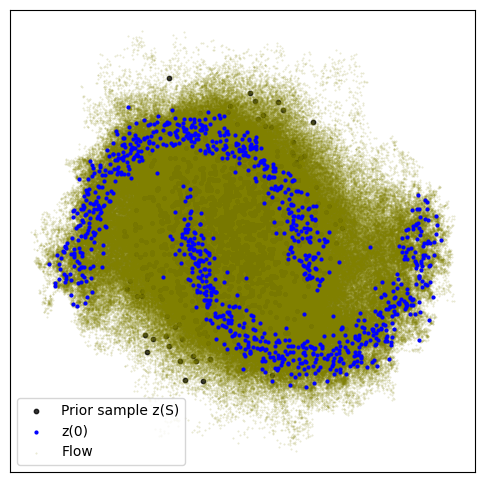

In [19]:
import matplotlib.pyplot as plt


traj = torch.stack(trajectory).cpu().detach().numpy()
plot_limit = 1024

plt.figure(figsize=(6, 6))

# Plot the first time point in black
plt.scatter(traj[0, :plot_limit, 0], traj[0, :plot_limit, 1], s=10, alpha=0.8, c="black", label="Prior sample z(S)")

# Plot all the rest of the time points except the first and last in olive
for i in range(1, traj.shape[0] - 1):
    plt.scatter(traj[i, :plot_limit, 0], traj[i, :plot_limit, 1], s=0.2, alpha=0.2, c="olive")

# Plot the last time point in blue
plt.scatter(traj[-1, :plot_limit, 0], traj[-1, :plot_limit, 1], s=4, alpha=1, c="blue", label="z(0)")

# Add a second legend for "Flow" since we can't label in the loop directly
plt.scatter([], [], s=0.2, alpha=0.2, c="olive", label="Flow")
plt.legend()
plt.xticks([])
plt.yticks([])
plt.show()

In [20]:
inf_size = 1024
sample = ddpm.sample_prior((inf_size, 2)).to(DEVICE)  # Start with noise
trajectory = [sample]
for t in schedule:
    full_t = torch.full((inf_size,), t).to(DEVICE)
    eps_hat = model(sample, full_t)  # calculate the vector field based on the definition of the model
    sample = ddpm.step(eps_hat, full_t, sample)
    trajectory.append(sample)  # save the trajectory for plotting purposes

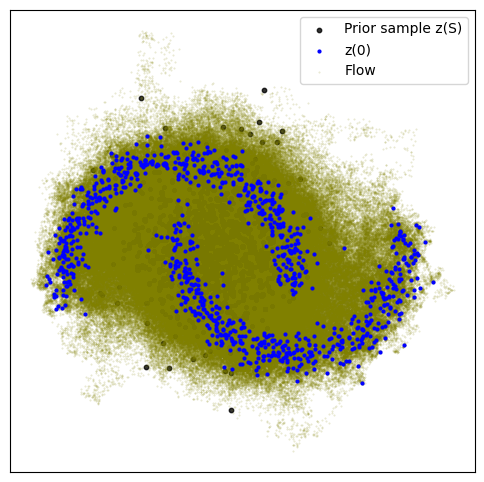

In [21]:
traj = torch.stack(trajectory).cpu().detach().numpy()
plot_limit = 1024

plt.figure(figsize=(6, 6))

# Plot the first time point in black
plt.scatter(traj[0, :plot_limit, 0], traj[0, :plot_limit, 1], s=10, alpha=0.8, c="black", label="Prior sample z(S)")

# Plot all the rest of the time points except the first and last in olive
for i in range(1, traj.shape[0] - 1):
    plt.scatter(traj[i, :plot_limit, 0], traj[i, :plot_limit, 1], s=0.2, alpha=0.2, c="olive")

# Plot the last time point in blue
plt.scatter(traj[-1, :plot_limit, 0], traj[-1, :plot_limit, 1], s=4, alpha=1, c="blue", label="z(0)")

# Add a second legend for "Flow" since we can't label in the loop directly
plt.scatter([], [], s=0.2, alpha=0.2, c="olive", label="Flow")
plt.legend()
plt.xticks([])
plt.yticks([])
plt.show()

## Notice that his yields very similar results to using the underlying score function in the stochastic score based CFM example

## Notice that there is no difference whether or not we convert the predicted noise to data inside thte .step() function

## Let's try other cool sampling functions

In [22]:
inf_size = 1024
schedule = DiscreteLinearInferenceSchedule(nsteps=1000, direction="diffusion").generate_schedule(device=DEVICE)
sample = ddpm.sample_prior((inf_size, 2)).to(DEVICE)  # Start with noise
trajectory = [sample]
for t in schedule:
    full_t = torch.full((inf_size,), t).to(DEVICE)
    eps_hat = model(sample, full_t)  # calculate the vector field based on the definition of the model
    sample = ddpm.step_ddim(eps_hat, full_t, sample)
    trajectory.append(sample)  # save the trajectory for plotting purposes

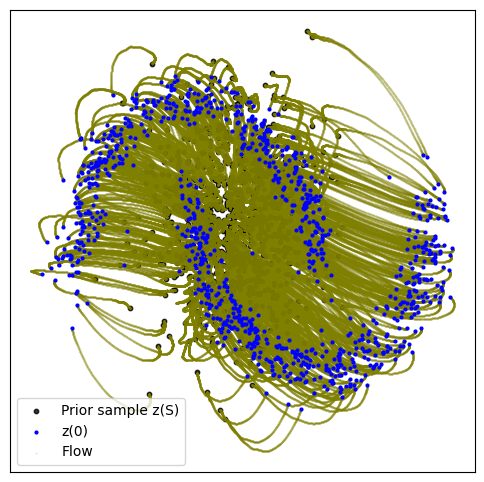

In [23]:
traj = torch.stack(trajectory).cpu().detach().numpy()
plot_limit = 1024

plt.figure(figsize=(6, 6))

# Plot the first time point in black
plt.scatter(traj[0, :plot_limit, 0], traj[0, :plot_limit, 1], s=10, alpha=0.8, c="black", label="Prior sample z(S)")

# Plot all the rest of the time points except the first and last in olive
for i in range(1, traj.shape[0] - 1):
    plt.scatter(traj[i, :plot_limit, 0], traj[i, :plot_limit, 1], s=0.2, alpha=0.2, c="olive")

# Plot the last time point in blue
plt.scatter(traj[-1, :plot_limit, 0], traj[-1, :plot_limit, 1], s=4, alpha=1, c="blue", label="z(0)")

# Add a second legend for "Flow" since we can't label in the loop directly
plt.scatter([], [], s=0.2, alpha=0.2, c="olive", label="Flow")
plt.legend()
plt.xticks([])
plt.yticks([])
plt.show()

# What happens when you sample from an untrained model with DDPM

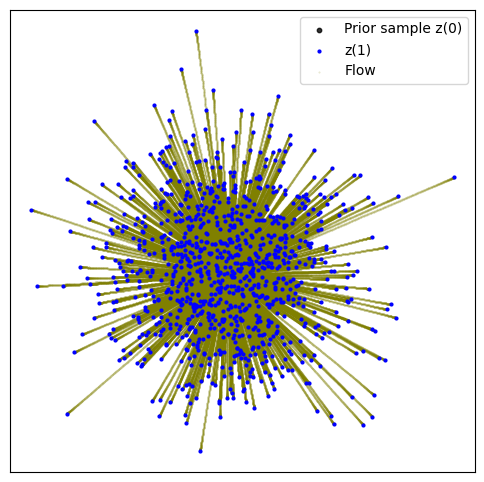

In [24]:
model = Network(dim_in=dim, dim_out=dim, dim_hids=[hidden_size] * num_hiddens).to(DEVICE)
inf_size = 1024
sample = ddpm.sample_prior((inf_size, 2)).to(DEVICE)
trajectory2 = [sample]
for t in schedule:
    full_t = torch.full((inf_size,), t).to(DEVICE)
    vt = model(sample, full_t)  # calculate the vector field based on the definition of the model
    sample = ddpm.step_noise(vt, full_t, sample)
    trajectory2.append(sample)  #
plot_limit = 1024
traj = torch.stack(trajectory2).cpu().detach().numpy()

plt.figure(figsize=(6, 6))

# Plot the first time point in black
plt.scatter(traj[0, :plot_limit, 0], traj[0, :plot_limit, 1], s=10, alpha=0.8, c="black", label="Prior sample z(0)")

# Plot all the rest of the time points except the first and last in olive
for i in range(1, traj.shape[0] - 1):
    plt.scatter(traj[i, :plot_limit, 0], traj[i, :plot_limit, 1], s=0.2, alpha=0.2, c="olive")

# Plot the last time point in blue
plt.scatter(traj[-1, :plot_limit, 0], traj[-1, :plot_limit, 1], s=4, alpha=1, c="blue", label="z(1)")

# Add a second legend for "Flow" since we can't label in the loop directly
plt.scatter([], [], s=0.2, alpha=0.2, c="olive", label="Flow")
plt.legend()
plt.xticks([])
plt.yticks([])
plt.show()

# Now let's switch the parameterization of DDPM from noise to data

Here instead of training the model to learn the noise we want to learn the raw data. Both options are valid and the choice of which depends on the underlying modeling task.

In [25]:
from bionemo.moco.distributions.prior.continuous.gaussian import GaussianPrior
from bionemo.moco.distributions.time.uniform import UniformTimeDistribution
from bionemo.moco.interpolants.discrete_time.continuous.ddpm import DDPM
from bionemo.moco.schedules.inference_time_schedules import DiscreteLinearInferenceSchedule
from bionemo.moco.schedules.noise.discrete_noise_schedules import DiscreteLinearNoiseSchedule


DEVICE = "cuda:0"
uniform_time = UniformTimeDistribution(discrete_time=True, nsteps=1000)
simple_prior = GaussianPrior()
ddpm = DDPM(
    time_distribution=uniform_time,
    prior_distribution=simple_prior,
    prediction_type="data",
    noise_schedule=DiscreteLinearNoiseSchedule(nsteps=1000),
    device=DEVICE,
)

## Let us first train the model with a weight such that it is theoretically equivalent to the simple noise matching loss. See Equation 9 from https://arxiv.org/pdf/2202.00512

In [26]:
# Place both the model and the interpolant on the same device
dim = 2
hidden_size = 128
num_hiddens = 3
batch_size = 256
model = Network(dim_in=dim, dim_out=dim, dim_hids=[hidden_size] * num_hiddens)
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)
DEVICE = "cuda"
model = model.to(DEVICE)
ddpm = ddpm.to_device(DEVICE)
for k in range(20000):
    optimizer.zero_grad()
    shape = (batch_size, dim)
    x0 = ddpm.sample_prior(shape).to(DEVICE)
    x1 = sample_moons(batch_size).to(DEVICE)

    t = ddpm.sample_time(batch_size)
    xt = ddpm.interpolate(x1, t, x0)

    x_hat = model(xt, t)
    loss = ddpm.loss(x_hat, x1, t, weight_type="data_to_noise").mean()

    loss.backward()
    optimizer.step()

    if (k + 1) % 1000 == 0:
        print(f"{k + 1}: loss {loss.item():0.3f}")

1000: loss 1.494
2000: loss 1.594
3000: loss 1.660
4000: loss 0.919
5000: loss 0.376
6000: loss 2.588
7000: loss 0.480
8000: loss 0.519
9000: loss 0.386
10000: loss 0.399
11000: loss 0.745
12000: loss 0.468
13000: loss 0.938
14000: loss 0.717
15000: loss 0.402
16000: loss 0.318
17000: loss 0.502
18000: loss 0.328
19000: loss 0.435
20000: loss 0.474


In [27]:
inf_size = 1024
sample = ddpm.sample_prior((inf_size, 2)).to(DEVICE)  # Start with noise
trajectory = [sample]
for t in schedule:
    full_t = torch.full((inf_size,), t).to(DEVICE)
    x_hat = model(sample, full_t)  # calculate the vector field based on the definition of the model
    sample = ddpm.step(x_hat, full_t, sample)
    trajectory.append(sample)  # save the trajectory for plotting purposes

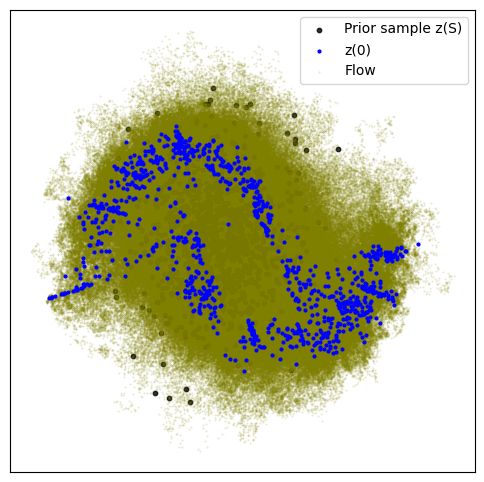

In [28]:
import matplotlib.pyplot as plt


traj = torch.stack(trajectory).cpu().detach().numpy()
plot_limit = 1024

plt.figure(figsize=(6, 6))

# Plot the first time point in black
plt.scatter(traj[0, :plot_limit, 0], traj[0, :plot_limit, 1], s=10, alpha=0.8, c="black", label="Prior sample z(S)")

# Plot all the rest of the time points except the first and last in olive
for i in range(1, traj.shape[0] - 1):
    plt.scatter(traj[i, :plot_limit, 0], traj[i, :plot_limit, 1], s=0.2, alpha=0.2, c="olive")

# Plot the last time point in blue
plt.scatter(traj[-1, :plot_limit, 0], traj[-1, :plot_limit, 1], s=4, alpha=1, c="blue", label="z(0)")

# Add a second legend for "Flow" since we can't label in the loop directly
plt.scatter([], [], s=0.2, alpha=0.2, c="olive", label="Flow")
plt.legend()
plt.xticks([])
plt.yticks([])
plt.show()

## Now let us train with no loss weighting to optimize a true data matching loss for comparison

In [29]:
# Place both the model and the interpolant on the same device
dim = 2
hidden_size = 128
num_hiddens = 3
batch_size = 256
model = Network(dim_in=dim, dim_out=dim, dim_hids=[hidden_size] * num_hiddens)
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)
DEVICE = "cuda"
model = model.to(DEVICE)
ddpm = ddpm.to_device(DEVICE)
for k in range(20000):
    optimizer.zero_grad()
    shape = (batch_size, dim)
    x0 = ddpm.sample_prior(shape).to(DEVICE)
    x1 = sample_moons(batch_size).to(DEVICE)

    t = ddpm.sample_time(batch_size)
    xt = ddpm.interpolate(x1, t, x0)

    x_hat = model(xt, t)
    loss = ddpm.loss(x_hat, x1, t, weight_type="ones").mean()

    loss.backward()
    optimizer.step()

    if (k + 1) % 1000 == 0:
        print(f"{k + 1}: loss {loss.item():0.3f}")

1000: loss 2.489
2000: loss 2.395
3000: loss 2.464
4000: loss 2.632
5000: loss 2.732
6000: loss 2.517
7000: loss 2.521
8000: loss 2.830
9000: loss 2.452
10000: loss 2.764
11000: loss 2.643
12000: loss 2.498
13000: loss 2.414
14000: loss 2.753
15000: loss 2.617
16000: loss 2.735
17000: loss 2.732
18000: loss 2.483
19000: loss 2.784
20000: loss 2.502


In [30]:
inf_size = 1024
sample = ddpm.sample_prior((inf_size, 2)).to(DEVICE)  # Start with noise
trajectory = [sample]
for t in schedule:
    full_t = torch.full((inf_size,), t).to(DEVICE)
    x_hat = model(sample, full_t)  # calculate the vector field based on the definition of the model
    sample = ddpm.step(x_hat, full_t, sample)
    trajectory.append(sample)  # save the trajectory for plotting purposes

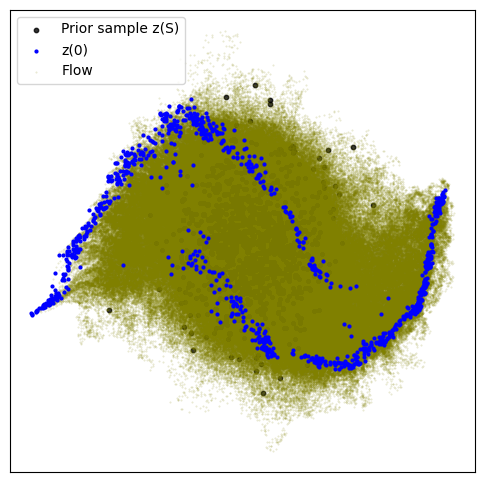

In [31]:
import matplotlib.pyplot as plt


traj = torch.stack(trajectory).cpu().detach().numpy()
plot_limit = 1024

plt.figure(figsize=(6, 6))

# Plot the first time point in black
plt.scatter(traj[0, :plot_limit, 0], traj[0, :plot_limit, 1], s=10, alpha=0.8, c="black", label="Prior sample z(S)")

# Plot all the rest of the time points except the first and last in olive
for i in range(1, traj.shape[0] - 1):
    plt.scatter(traj[i, :plot_limit, 0], traj[i, :plot_limit, 1], s=0.2, alpha=0.2, c="olive")

# Plot the last time point in blue
plt.scatter(traj[-1, :plot_limit, 0], traj[-1, :plot_limit, 1], s=4, alpha=1, c="blue", label="z(0)")

# Add a second legend for "Flow" since we can't label in the loop directly
plt.scatter([], [], s=0.2, alpha=0.2, c="olive", label="Flow")
plt.legend()
plt.xticks([])
plt.yticks([])
plt.show()

### The choice in data vs noise and variance schedule are hyperparameters that must be tuned to each task

### many of these choices are empirical and part of the tuning process to best model your data via noise, data, or even velocity prediction.

# Now let's try a continuous time analog interpolant to DDPM called VDM

### This interpolant was used in Chroma and is described in great detail here https://www.biorxiv.org/content/10.1101/2022.12.01.518682v1.full.pdf

In [32]:
from bionemo.moco.distributions.prior.continuous.gaussian import GaussianPrior
from bionemo.moco.distributions.time import UniformTimeDistribution
from bionemo.moco.interpolants import VDM
from bionemo.moco.schedules.inference_time_schedules import LinearInferenceSchedule
from bionemo.moco.schedules.noise.continuous_snr_transforms import (
    LinearLogInterpolatedSNRTransform,
)


DEVICE = "cuda:0"
uniform_time = UniformTimeDistribution(discrete_time=False)
simple_prior = GaussianPrior()
vdm = VDM(
    time_distribution=uniform_time,
    prior_distribution=simple_prior,
    prediction_type="data",
    noise_schedule=LinearLogInterpolatedSNRTransform(),
    device=DEVICE,
)
schedule = LinearInferenceSchedule(nsteps=1000, direction="diffusion")

In [33]:
# Place both the model and the interpolant on the same device
dim = 2
hidden_size = 128
num_hiddens = 3
batch_size = 256
model = Network(dim_in=dim, dim_out=dim, dim_hids=[hidden_size] * num_hiddens)
DEVICE = "cuda"
model = model.to(DEVICE)

In [34]:
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)
for k in range(20000):
    optimizer.zero_grad()
    shape = (batch_size, dim)
    x0 = vdm.sample_prior(shape).to(DEVICE)
    x1 = sample_moons(batch_size).to(DEVICE)

    t = vdm.sample_time(batch_size)
    xt = vdm.interpolate(x1, t, x0)

    x_hat = model(xt, t)
    loss = vdm.loss(x_hat, x1, t, weight_type="ones").mean()

    loss.backward()
    optimizer.step()

    if (k + 1) % 1000 == 0:
        print(f"{k + 1}: loss {loss.item():0.3f}")

1000: loss 1.479
2000: loss 1.102
3000: loss 1.224
4000: loss 0.964
5000: loss 1.172
6000: loss 1.354
7000: loss 1.151
8000: loss 1.016
9000: loss 1.399
10000: loss 1.194
11000: loss 1.213
12000: loss 1.418
13000: loss 1.101
14000: loss 0.953
15000: loss 1.079
16000: loss 1.107
17000: loss 1.231
18000: loss 1.280
19000: loss 1.073
20000: loss 0.935


In [35]:
inf_size = 1024
sample = vdm.sample_prior((inf_size, 2)).to(DEVICE)  # Start with noise
trajectory = [sample]
ts = schedule.generate_schedule()
dts = schedule.discretize()
for dt, t in zip(dts, ts):
    full_t = torch.full((inf_size,), t).to(DEVICE)
    x_hat = model(sample, full_t)  # calculate the vector field based on the definition of the model
    sample = vdm.step(x_hat, full_t, sample, dt)
    trajectory.append(sample)  # save the trajectory for plotting purposes

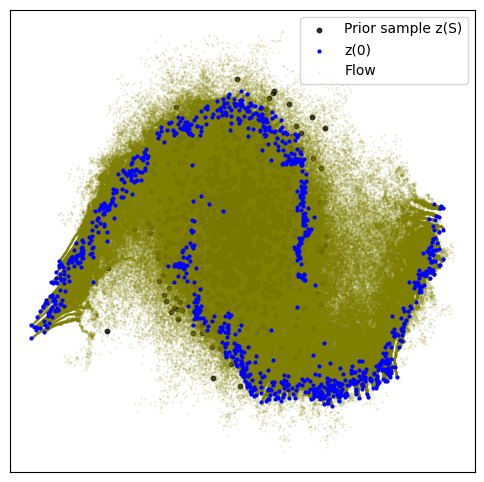

In [36]:
import matplotlib.pyplot as plt


traj = torch.stack(trajectory).cpu().detach().numpy()
plot_limit = 1024

plt.figure(figsize=(6, 6))

# Plot the first time point in black
plt.scatter(traj[0, :plot_limit, 0], traj[0, :plot_limit, 1], s=10, alpha=0.8, c="black", label="Prior sample z(S)")

# Plot all the rest of the time points except the first and last in olive
for i in range(1, traj.shape[0] - 1):
    plt.scatter(traj[i, :plot_limit, 0], traj[i, :plot_limit, 1], s=0.2, alpha=0.2, c="olive")

# Plot the last time point in blue
plt.scatter(traj[-1, :plot_limit, 0], traj[-1, :plot_limit, 1], s=4, alpha=1, c="blue", label="z(0)")

# Add a second legend for "Flow" since we can't label in the loop directly
plt.scatter([], [], s=0.2, alpha=0.2, c="olive", label="Flow")
plt.legend()
plt.xticks([])
plt.yticks([])
plt.show()

In [37]:
inf_size = 1024
sample = vdm.sample_prior((inf_size, 2)).to(DEVICE)  # Start with noise
trajectory = [sample]
ts = schedule.generate_schedule()
dts = schedule.discretize()
for dt, t in zip(dts, ts):
    full_t = torch.full((inf_size,), t).to(DEVICE)
    x_hat = model(sample, full_t)  # calculate the vector field based on the definition of the model
    sample = vdm.step_ddim(x_hat, full_t, sample, dt)
    trajectory.append(sample)  # save the trajectory for plotting purposes

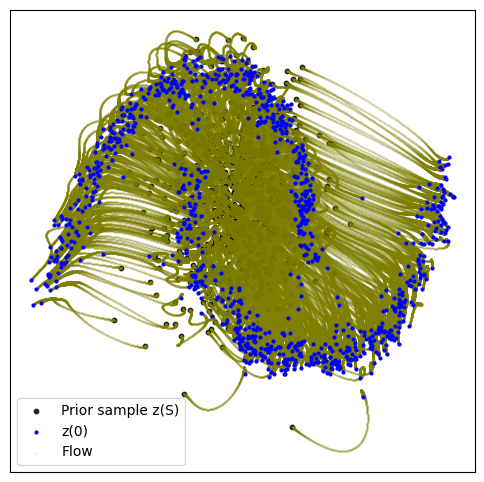

In [38]:
import matplotlib.pyplot as plt


traj = torch.stack(trajectory).cpu().detach().numpy()
plot_limit = 1024

plt.figure(figsize=(6, 6))

# Plot the first time point in black
plt.scatter(traj[0, :plot_limit, 0], traj[0, :plot_limit, 1], s=10, alpha=0.8, c="black", label="Prior sample z(S)")

# Plot all the rest of the time points except the first and last in olive
for i in range(1, traj.shape[0] - 1):
    plt.scatter(traj[i, :plot_limit, 0], traj[i, :plot_limit, 1], s=0.2, alpha=0.2, c="olive")

# Plot the last time point in blue
plt.scatter(traj[-1, :plot_limit, 0], traj[-1, :plot_limit, 1], s=4, alpha=1, c="blue", label="z(0)")

# Add a second legend for "Flow" since we can't label in the loop directly
plt.scatter([], [], s=0.2, alpha=0.2, c="olive", label="Flow")
plt.legend()
plt.xticks([])
plt.yticks([])
plt.show()

## What is interesting here is that the deterministic sampling of DDIM best recovers the Flow Matching ODE samples

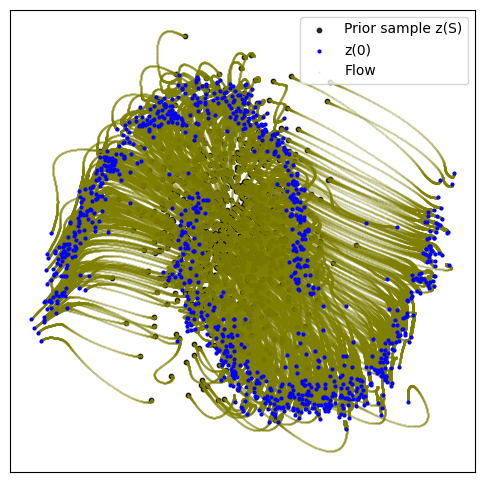

In [39]:
inf_size = 1024
sample = vdm.sample_prior((inf_size, 2)).to(DEVICE)  # Start with noise
trajectory = [sample]
ts = schedule.generate_schedule()
dts = schedule.discretize()
for dt, t in zip(dts, ts):
    full_t = torch.full((inf_size,), t).to(DEVICE)
    x_hat = model(sample, full_t)  # calculate the vector field based on the definition of the model
    # sample = vdm.step_hybrid_sde(x_hat, full_t, sample, dt)
    sample = vdm.step_ode(x_hat, full_t, sample, dt)
    trajectory.append(sample)  # save the trajectory for plotting purposes

traj = torch.stack(trajectory).cpu().detach().numpy()
plot_limit = 1024

plt.figure(figsize=(6, 6))

# Plot the first time point in black
plt.scatter(traj[0, :plot_limit, 0], traj[0, :plot_limit, 1], s=10, alpha=0.8, c="black", label="Prior sample z(S)")

# Plot all the rest of the time points except the first and last in olive
for i in range(1, traj.shape[0] - 1):
    plt.scatter(traj[i, :plot_limit, 0], traj[i, :plot_limit, 1], s=0.2, alpha=0.2, c="olive")

# Plot the last time point in blue
plt.scatter(traj[-1, :plot_limit, 0], traj[-1, :plot_limit, 1], s=4, alpha=1, c="blue", label="z(0)")

# Add a second legend for "Flow" since we can't label in the loop directly
plt.scatter([], [], s=0.2, alpha=0.2, c="olive", label="Flow")
plt.legend()
plt.xticks([])
plt.yticks([])
plt.show()

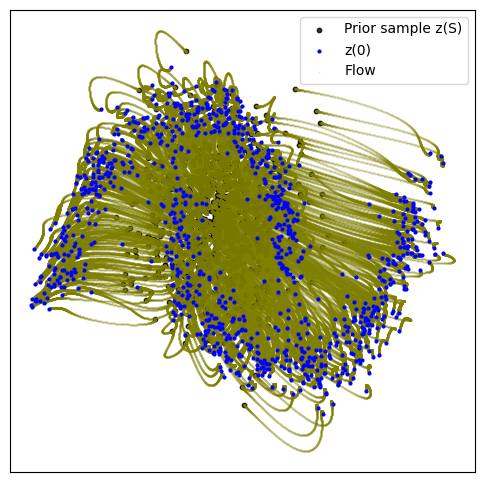

In [40]:
inf_size = 1024
sample = vdm.sample_prior((inf_size, 2)).to(DEVICE)  # Start with noise
trajectory = [sample]
ts = schedule.generate_schedule()
dts = schedule.discretize()
for dt, t in zip(dts, ts):
    full_t = torch.full((inf_size,), t).to(DEVICE)
    x_hat = model(sample, full_t)  # calculate the vector field based on the definition of the model
    # sample = vdm.step_hybrid_sde(x_hat, full_t, sample, dt)
    sample = vdm.step_ode(x_hat, full_t, sample, dt, temperature=1.5)
    trajectory.append(sample)  # save the trajectory for plotting purposes

traj = torch.stack(trajectory).cpu().detach().numpy()
plot_limit = 1024

# Assuming traj is your tensor and traj.shape = (N, 2000, 2)
# where N is the number of time points, 2000 is the number of samples at each time point, and 2 is for the x and y coordinates.

plt.figure(figsize=(6, 6))

# Plot the first time point in black
plt.scatter(traj[0, :plot_limit, 0], traj[0, :plot_limit, 1], s=10, alpha=0.8, c="black", label="Prior sample z(S)")

# Plot all the rest of the time points except the first and last in olive
for i in range(1, traj.shape[0] - 1):
    plt.scatter(traj[i, :plot_limit, 0], traj[i, :plot_limit, 1], s=0.2, alpha=0.2, c="olive")

# Plot the last time point in blue
plt.scatter(traj[-1, :plot_limit, 0], traj[-1, :plot_limit, 1], s=4, alpha=1, c="blue", label="z(0)")

# Add a second legend for "Flow" since we can't label in the loop directly
plt.scatter([], [], s=0.2, alpha=0.2, c="olive", label="Flow")
plt.legend()
plt.xticks([])
plt.yticks([])
plt.show()

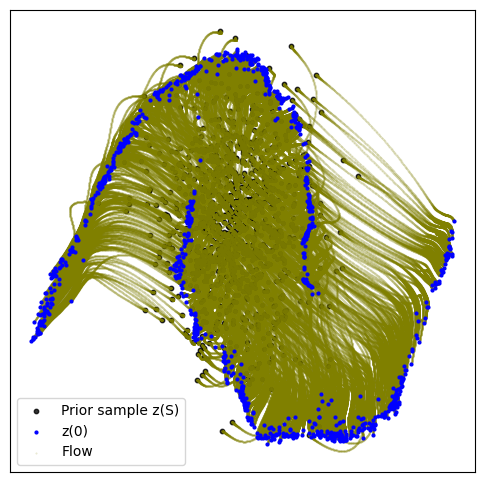

In [41]:
inf_size = 1024
sample = vdm.sample_prior((inf_size, 2)).to(DEVICE)  # Start with noise
trajectory = [sample]
ts = schedule.generate_schedule()
dts = schedule.discretize()
for dt, t in zip(dts, ts):
    full_t = torch.full((inf_size,), t).to(DEVICE)
    x_hat = model(sample, full_t)  # calculate the vector field based on the definition of the model
    # sample = vdm.step_hybrid_sde(x_hat, full_t, sample, dt)
    sample = vdm.step_ode(x_hat, full_t, sample, dt, temperature=0.5)
    trajectory.append(sample)  # save the trajectory for plotting purposes

traj = torch.stack(trajectory).cpu().detach().numpy()
plot_limit = 1024

plt.figure(figsize=(6, 6))

# Plot the first time point in black
plt.scatter(traj[0, :plot_limit, 0], traj[0, :plot_limit, 1], s=10, alpha=0.8, c="black", label="Prior sample z(S)")

# Plot all the rest of the time points except the first and last in olive
for i in range(1, traj.shape[0] - 1):
    plt.scatter(traj[i, :plot_limit, 0], traj[i, :plot_limit, 1], s=0.2, alpha=0.2, c="olive")

# Plot the last time point in blue
plt.scatter(traj[-1, :plot_limit, 0], traj[-1, :plot_limit, 1], s=4, alpha=1, c="blue", label="z(0)")

# Add a second legend for "Flow" since we can't label in the loop directly
plt.scatter([], [], s=0.2, alpha=0.2, c="olive", label="Flow")
plt.legend()
plt.xticks([])
plt.yticks([])
plt.show()

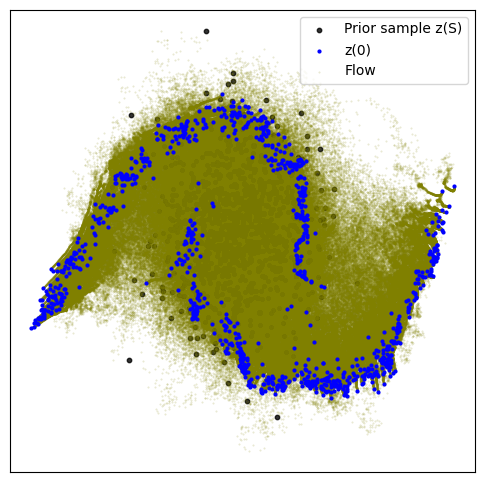

In [42]:
inf_size = 1024
sample = vdm.sample_prior((inf_size, 2)).to(DEVICE)  # Start with noise
trajectory = [sample]
ts = schedule.generate_schedule()
dts = schedule.discretize()
for dt, t in zip(dts, ts):
    full_t = torch.full((inf_size,), t).to(DEVICE)
    x_hat = model(sample, full_t)  # calculate the vector field based on the definition of the model
    sample = vdm.step_hybrid_sde(x_hat, full_t, sample, dt)
    # sample = vdm.step_ode(x_hat, full_t, sample, dt)
    trajectory.append(sample)  # save the trajectory for plotting purposes

traj = torch.stack(trajectory).cpu().detach().numpy()
plot_limit = 1024

plt.figure(figsize=(6, 6))

# Plot the first time point in black
plt.scatter(traj[0, :plot_limit, 0], traj[0, :plot_limit, 1], s=10, alpha=0.8, c="black", label="Prior sample z(S)")

# Plot all the rest of the time points except the first and last in olive
for i in range(1, traj.shape[0] - 1):
    plt.scatter(traj[i, :plot_limit, 0], traj[i, :plot_limit, 1], s=0.2, alpha=0.2, c="olive")

# Plot the last time point in blue
plt.scatter(traj[-1, :plot_limit, 0], traj[-1, :plot_limit, 1], s=4, alpha=1, c="blue", label="z(0)")

# Add a second legend for "Flow" since we can't label in the loop directly
plt.scatter([], [], s=0.2, alpha=0.2, c="olive", label="Flow")
plt.legend()
plt.xticks([])
plt.yticks([])
plt.show()